# Final Project - Analysis of the Effect of Reach on the Number of Significant Strikes Landed per Min in the UFC Fights in Account to Heights
Group Members: Byeong Heon Ahn (bha233), Kanishk Aggarwal (ka3506), Dhruv Topiwala (dmt9779)

## Hypothesis

For this project, we will analyze the causal effect of the reach of the fighters on the number of significant strikes landed per min. To analyze both the total and direct causal effect of the reach on the number of significant strikes landed per min, we will use the reach and the number of significant strikes landed per min of the individual fighters on the blue side. The height of the fighters on the blue side will also be considered as one of the potential confounds since it reasonably influences both the reach and the number of significant strikes landed per min. As a hypothesis, we assume that the reach will be positively proportional to the the number of significant strikes landed per min when the height is accounted (longer the reach more significant strikes the fighter could land per minute).

## Dataset

We will use the $\href{https://www.kaggle.com/datasets/mdabbert/ultimate-ufc-dataset/data}{Ultimate-UFC-Fights-dataset}$ (ufc_master.csv), which includes the various data of each fights. Since we are exploring the hypothesis of the influence of the reach on the number of significant strikes landed per min while the height is also considered as a confound, the reach, height, and the number of significant strikes landed per min of the fighters on the blue side will be used in this project.

To use the dataset, we downloaded the csv file and included in the project folder so it is easier to access and handle the data through:

pd.read_csv("Data/ufc_master.csv")

For this project, we will only be using the "BlueHeightCms", "BlueReachCms", and "BlueAvgSigStrLanded".

## Causal Model

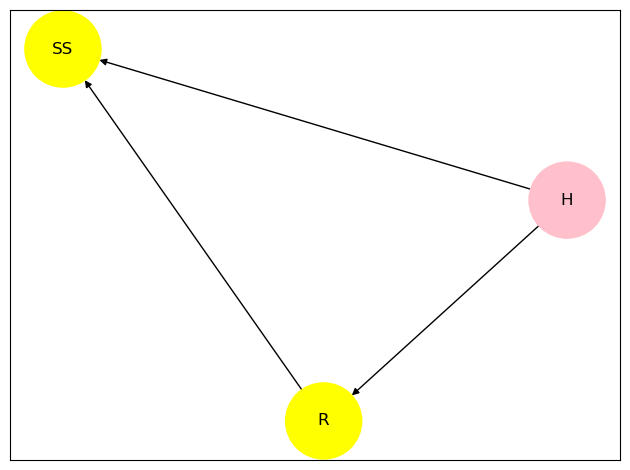

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
graph.add_edges_from([("H", "R"), ("H","SS"), ("R","SS")])
nx.draw_networkx(graph, arrows=True, node_color= ["pink", "yellow", "yellow"], node_size=3000)
plt.tight_layout()

The DAG graph above represents the causal relationships between the reach (R), height (H), and the number of significant strikes landed per min (SS). As briefly addressed in the hypothesis, the associations between the variables are made under a reasonable scientific model:

1. R = $f_{R} (H)$

The height of a fighter (H) directly influences the reach of the fighter (R) as the reach gets longer as human grows and gets taller.

2. SS = $f_{SS} (R, H)$

Both the the reach (R) and the height (H) directly affects the number of significant strikes landed per min since having the longer reach and being taller than the opponent means that the fighter has a bigger safety zone and easier to reach to the opponent so that one can land more significant strikes easily and safely.

Thus, as we see that the height (H) is a confounder (H affects both R and SS  [R $\leftarrow$ H $\rightarrow$ SS]), we need to condition on the height when measuring both the direct and total causal effects of the reach on the number of significant strikes landed per min; the height will be included in the model to measure both the direct and total causal effects of R on SS.

## Statistical Model

### Prior Predictive Simulation

Before the prior predictive simulation, the ufc_master.csv data will be explored.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as stats
import networkx as nx
from scipy.special import expit as logistic

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [59]:
df = pd.read_csv("Data/ufc-master.csv")
columns = ["BlueReachCms", "BlueHeightCms", "BlueAvgSigStrLanded"]
print(columns)
df = df[columns]
df.head()

['BlueReachCms', 'BlueHeightCms', 'BlueAvgSigStrLanded']


,BlueReachCms,BlueHeightCms,BlueAvgSigStrLanded
0,175.26,172.72,0.00
1,187.96,190.50,5.50
2,203.20,200.66,5.13
3,177.80,175.26,3.74
4,177.80,177.80,4.41


#### Research on Average Reach, Height, and Number of Significant Strikes Landed per Min of UFC Fighters

From the research, the $\href{https://www.reference.com/science-technology/average-human-arm-span-c07bdf92e5fa8755}{Reference}$ website states that the average arm span length for man is about 5 feet 9 inches (175.26 cm). Since it was hard to find the average reach length of the UFC fighters across all weight classes, we will use this general average arm span length information for man as the average reach length of the UFC fighters. Thus, as an estimation, we are going to use the standard deviation of 10.00 cm with 175.26 cm as the average reach length of the UFC fighters.

According to the $\href{https://jokermag.com/average-height-ufc-fighters/}{jokermag}$ website, it states the average height of the UFC fighters across all weight classes is about 5 feet 9.5 inches (176.62 cm). Thus, as an estimation, we are going to use the standard deviation of 10.00 cm with 176.62 cm as the average height of the UFC fighters.

From the research, we could not find the average number of significant strikes landed per min of the UFC fighters. However, according to the $\href{http://statleaders.ufc.com/career?fighter_status=0}{Official-UFC-Record-Book}$, the highest significant strikes landed per minute is 8.10. Since the possible least significant strikes landed per minute will be 0, we are going to estimate the average number of significant strikes landed per min is 4.05 with a standard deviation of 1.

With this researched information, we see that in the plots above, there are data points which have the value for the number of significant strikes landed per min greater than 8.10. We will double-check if the pre-processed dataset has the appropriate data values for the number of significant strikes landed per min.

In [60]:
# The min of the number of significant strikes landed per min
num_sig_str = ["BlueAvgSigStrLanded"]
print("The minimum number of significant strikes landed per min:")
print(df[num_sig_str].min())

# The max of the number of significant strikes landed per min
print("\nThe maximum number of significant strikes landed per min:")
print(df[num_sig_str].max())

The minimum number of significant strikes landed per min:
BlueAvgSigStrLanded    0.0
dtype: float64

The maximum number of significant strikes landed per min:
BlueAvgSigStrLanded    154.0
dtype: float64


From the min and max values above, we see that while the minimum values is reasonable (sometimes there are some fights which ends in few seconds with just one significant attack, in which case the significant attack of the person lost would be 0), it is not reasonable that a fighter would land 154 significant strikes per minute in a fight. Also, as the official UFC Record Book states the highest significant strikes landed per min is 8.10, we can conclude that some of the data points in the datasets are not reasonable. Thus, we will further process the data points that has the number of significant strikes landed per min over 8.10. Also, before we proceed further, we will clean up and process the dataset.

In [63]:
# Cleaning dataset for any data point that has NaN value
processed_data = df.dropna()

# Cleaning dataset for any data point that has the BlueAvgSigStrLanded values greater than 8.10
processed_df = processed_df[processed_df['BlueAvgSigStrLanded'] <= 8.10]

# Cleaning dataset for any data point that has the BlueReachCms or BlueHeightCms < 100
processed_df = processed_df[(processed_df['BlueReachCms'] > 100) & (processed_df['BlueHeightCms'] >100)]

# Check if the processed dataset is clean
print("Any NaN in the processed dataset:\n", processed_df.isna().any().any())

print("\nAny number of significant strike landed per min greater than 8.10:\n", np.where(processed_df[["BlueAvgSigStrLanded"]]>8.10))

print("\nAny reach or height of the figher less than 100:\n", np.where(processed_df[["BlueReachCms", "BlueHeightCms"]]<100))

Any NaN in the processed dataset:
 False

Any number of significant strike landed per min greater than 8.10:
 (array([], dtype=int64), array([], dtype=int64))

Any reach or height of the figher less than 100:
 (array([], dtype=int64), array([], dtype=int64))


In [65]:
# The min of the number of significant strikes landed per min
num_sig_str = ["BlueAvgSigStrLanded"]
print("The minimum number of significant strikes landed per min in processed dataset:")
print(processed_df[num_sig_str].min())

# The max of the number of significant strikes landed per min
print("\nThe maximum number of significant strikes landed per min in processed dataset:")
print(processed_df[num_sig_str].max())

The minimum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    0.0
dtype: float64

The maximum number of significant strikes landed per min in processed dataset:
BlueAvgSigStrLanded    8.07
dtype: float64


We will now plot the standardized data points so it will visualize the min and max range of the variables.

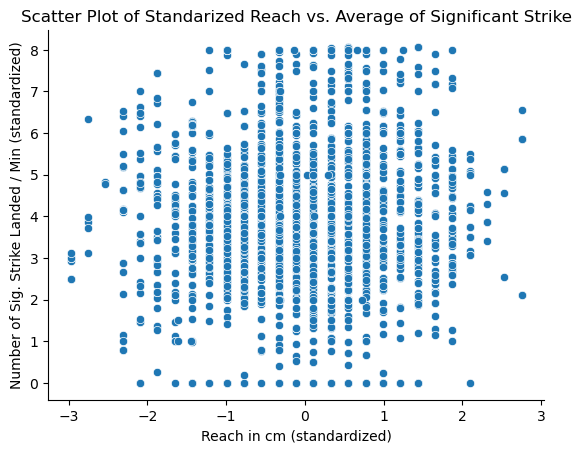

In [66]:
sns.scatterplot(x = standardize(processed_df.BlueReachCms), y = processed_df.BlueAvgSigStrLanded)
plt.xlabel("Reach in cm (standardized)")
plt.ylabel("Number of Sig. Strike Landed / Min (standardized)")
plt.title("Scatter Plot of Standarized Reach vs. Average of Significant Strike")
sns.despine();

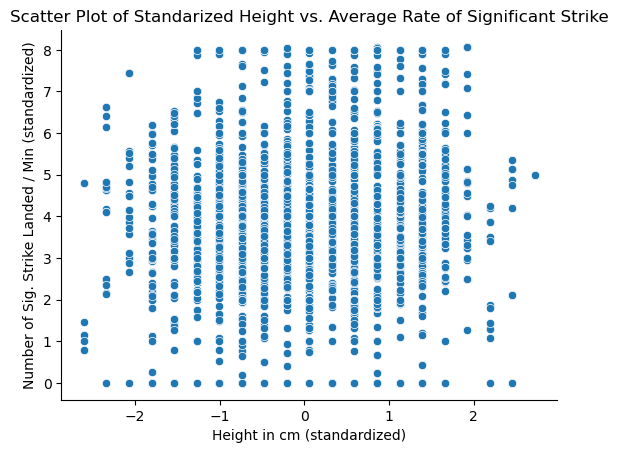

In [67]:
sns.scatterplot(x = standardize(processed_df.BlueHeightCms), y = processed_df.BlueAvgSigStrLanded)
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Number of Sig. Strike Landed / Min (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Average Rate of Significant Strike")
sns.despine();

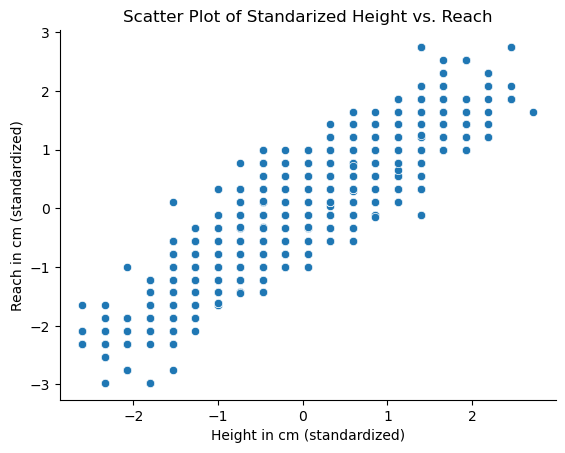

In [68]:
sns.scatterplot(x = standardize(processed_df.BlueHeightCms), y = standardize(processed_df.BlueReachCms))
plt.xlabel("Height in cm (standardized)")
plt.ylabel("Reach in cm (standardized)")
plt.title("Scatter Plot of Standarized Height vs. Reach")
sns.despine();

In [13]:
# # First prior simulation
# NUM_LINES = 7

# x_seq = np.linspace(-3.96, 3.71, 50)

# alpha = stats.norm.rvs(50, 5, size=NUM_LINES, random_state = 42)
# beta = stats.norm.rvs(0, 10, size=NUM_LINES, random_state = 42)

# for i in range(NUM_LINES):
#     ys = alpha[i] + beta[i] * x_seq
#     _ = plt.plot(x_seq, ys, color="#e06666")
    
# _ = plt.ylabel("win rate")
# _ = plt.xlabel("X")
# _ = plt.title("Prior Simulation for the Difference of Reach")
# _ = plt.xlim((-4, 4))
# _ = plt.ylim((0,100))
# sns.despine();

For the second prior simulation, 

#### Prior Predictive Simulation for Difference of Significant Strike Count

For the difference of significant strike count, the normal distribution will be used since the difference can be positive or negative depending on the number of significant strikes of blue and red fighters. For the range of the variable, the standardized minimum and maximum values of the significant strike count difference among every fighter will be used. Before proceeding to find the min and max values, we will check if there is any data with NaN values and recalculate the difference of the significant strike count again to make sure the data is correct.

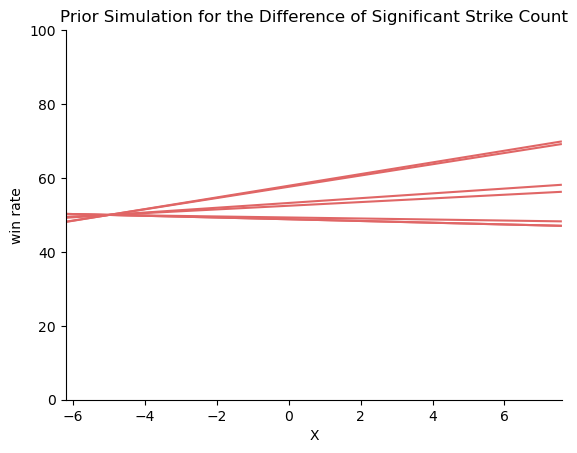

In [26]:
# First prior simulation
NUM_LINES = 7

x_seq = np.linspace(-6.15, 7.57, 50)

alpha = stats.norm.rvs(0.5, 0.1, size=NUM_LINES, random_state = 42)
beta = stats.norm.rvs(0, 1, size=NUM_LINES, random_state = 42)

for i in range(NUM_LINES):
    ys = alpha[i] + beta[i] * x_seq
    _ = plt.plot(x_seq, ys, color="#e06666")
    
_ = plt.ylabel("win rate")
_ = plt.xlabel("X")
_ = plt.title("Prior Simulation for the Difference of Significant Strike Count")
_ = plt.xlim((-6.2, 7.6))
_ = plt.ylim((0,100))
sns.despine();

### Statistical Model to Predict the Winner

Before we start with the statistical model, we will first make sure to clean up the data so that it would exclude data that has NaN values.